# Recency Frequency Monetary (RFM) - segmentation by exchange

apply shopping segmentation to identify those exchanges that are recently, frequenty and high monetary

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import datetime as dt

#### load data

In [2]:
cable_theft_df = pd.read_csv("/home/jupyter/projects/cable-theft/data/cable_theft.csv")

#### create incident date

In [3]:
cable_theft_df['incident_dt'] = pd.to_datetime(dict(year=cable_theft_df.Year, month=cable_theft_df.Month, day=cable_theft_df.Day))

#### exchange indicator

In [4]:
cable_theft_df['exchange'] = cable_theft_df['Exchange'].str.lower().str.strip()

#### theft indicator

In [5]:
cable_theft_df['type'] = cable_theft_df['Cut/ Theft'].str.lower().str.strip()

#### thefts (from 2020?)

In [6]:
cable_theft_df = cable_theft_df[cable_theft_df['type'] == 'theft']
#cable_theft_df = cable_theft_df[cable_theft_df['Year'] >= 2020]

#### select columns for rfm

In [7]:
rfm_df = cable_theft_df[['incident_dt','SIR Number', 'Total Cost','exchange']]
rfm_df

,incident_dt,SIR Number,Total Cost,exchange
2,2002-08-16,11005565,NaN,downton
4,2007-04-04,7000158,NaN,collyhurst
5,2007-04-05,7000221,NaN,albert dock
6,2007-04-05,7000236,NaN,cheetham
7,2007-04-05,7000244,NaN,cambuslang
...,...,...,...,...
11454,2024-06-25,24002812,3652.8,eastleigh
11455,2024-06-25,24002787,2361.0,blakeney
11456,2024-06-26,24002810,20013.4,tilbury
11458,2024-06-27,28002850,0.0,stanford le hope


#### drop na

In [8]:
rfm_df = rfm_df.dropna().reset_index(drop=True)
rfm_df

,incident_dt,SIR Number,Total Cost,exchange
0,2017-04-13,17000598,42866.94,haverton hill
1,2017-04-15,17000675,20667.00,haverton hill
2,2017-04-17,17000701,0.00,haverton hill
3,2017-04-21,17000972,17008.00,haverton hill
4,2017-05-24,17002752,1751.62,sevenoaks
...,...,...,...,...
585,2024-06-25,24002812,3652.80,eastleigh
586,2024-06-25,24002787,2361.00,blakeney
587,2024-06-26,24002810,20013.40,tilbury
588,2024-06-27,28002850,0.00,stanford le hope


In [9]:
# Set a reference date for calculations
today_date = dt.datetime(2024, 6, 28)  

In [10]:
# Group by customer ID and aggregate metrics: recency (days since last purchase), 
# frequency (number of purchases), monetary (total spend)
group_rfm_df = pd.DataFrame(rfm_df.groupby('exchange').agg(
        {'incident_dt': lambda date: (today_date - date.max()).days,
         'SIR Number': lambda num: num.nunique(),
         'Total Cost': lambda cost: cost.sum()}))

In [11]:
#group_rfm_df.reset_index(inplace=True)

In [12]:
group_rfm_df

,incident_dt,SIR Number,Total Cost
exchange,,,
adwick le street,834,5,109449.64
alfriston,739,1,15052.75
alva,1396,1,46027.28
ascot,604,1,0.00
ash green,60,3,61030.62
...,...,...,...
woolwich,437,4,99937.58
wrexham north,773,2,392024.06
wroughton,41,3,28608.00


In [13]:
group_rfm_df.columns = ['recency','frequency','monetary']

In [14]:
# Calculate recency score based on quantiles, assigning labels from 1 to 5 (1 being lowest recency)
group_rfm_df["recency_score"] = pd.qcut(group_rfm_df['recency'], 5, labels=[5, 4, 3, 2, 1])

In [15]:
# Calculate frequency score based on rank quantiles, assigning labels from 1 to 5 (1 being lowest frequency)
group_rfm_df["frequency_score"] = pd.qcut(group_rfm_df["frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

In [16]:
group_rfm_df['monetary_score'] = pd.qcut(group_rfm_df['monetary'],5,labels=[1,2,3,4,5])

In [17]:
# Combine recency and frequency scores to create RFM segment
group_rfm_df['segment'] = group_rfm_df['recency_score'].astype(str) + group_rfm_df['frequency_score'].astype(str)
group_rfm_df.head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,segment
exchange,,,,,,,
adwick le street,834,5,109449.64,2,5,5,25
alfriston,739,1,15052.75,3,1,3,31
alva,1396,1,46027.28,1,1,4,11
ascot,604,1,0.00,4,1,1,41
ash green,60,3,61030.62,5,4,4,54


In [18]:
# Mapping of segments to their corresponding customer segments
seg_map = {
r'[1-2][1-2]': 'hibernating',
r'[1-2][3-4]': 'at_risk',
r'[1-2]5': 'cant_lose',
r'3[1-2]': 'about_to_sleep',
r'33': 'need_attention',
r'[3-4][4-5]': 'loyal_customers',
r'41': 'promising',
r'51': 'new_customers',
r'[4-5][2-3]': 'potential_loyalists',
r'5[4-5]': 'champions'
}

In [19]:
# Map RFM segments to corresponding customer segments using predefined seg_map
group_rfm_df['segment'] = group_rfm_df['segment'].replace(seg_map, regex=True)
group_rfm_df

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,segment
exchange,,,,,,,
adwick le street,834,5,109449.64,2,5,5,cant_lose
alfriston,739,1,15052.75,3,1,3,about_to_sleep
alva,1396,1,46027.28,1,1,4,hibernating
ascot,604,1,0.00,4,1,1,promising
ash green,60,3,61030.62,5,4,4,champions
...,...,...,...,...,...,...,...
woolwich,437,4,99937.58,4,5,5,loyal_customers
wrexham north,773,2,392024.06,2,4,5,at_risk
wroughton,41,3,28608.00,5,5,3,champions


In [20]:
group_rfm_df[group_rfm_df.segment.isin(['champions'])]

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,segment
exchange,,,,,,,
ash green,60,3,61030.6200,5,4,4,champions
bradwell abbey,24,3,74129.5000,5,4,5,champions
chislehurst,224,3,236011.8300,5,4,5,champions
eastleigh,3,2,8786.2400,5,4,2,champions
failsworth,63,2,1586.8600,5,4,1,champions
farnham common,67,2,57399.2700,5,4,4,champions
farningham,102,3,104727.8000,5,5,5,champions
hartlepool,173,4,28975.7300,5,5,3,champions
haverton hill,194,6,120639.9800,5,5,5,champions


In [21]:
group_rfm_df['recency_score'] = pd.to_numeric(group_rfm_df['recency_score'], errors='coerce')
group_rfm_df['frequency_score'] = pd.to_numeric(group_rfm_df['frequency_score'], errors='coerce')
group_rfm_df['monetary'] = pd.to_numeric(group_rfm_df['monetary'], errors='coerce')

In [22]:
summary_df = group_rfm_df[["segment","monetary","frequency_score","recency_score"]].groupby("segment", as_index=False).agg(["mean","sum"])
summary_df.columns
summary_df.columns = ['segment','monetary_mean','monetary_sum','frequency_score_mean','frequency_score_sum','recency_score_mean','recency_score_sum']

In [23]:
summary_df.columns

Index(['segment', 'monetary_mean', 'monetary_sum', 'frequency_score_mean',
       'frequency_score_sum', 'recency_score_mean', 'recency_score_sum'],
      dtype='object')

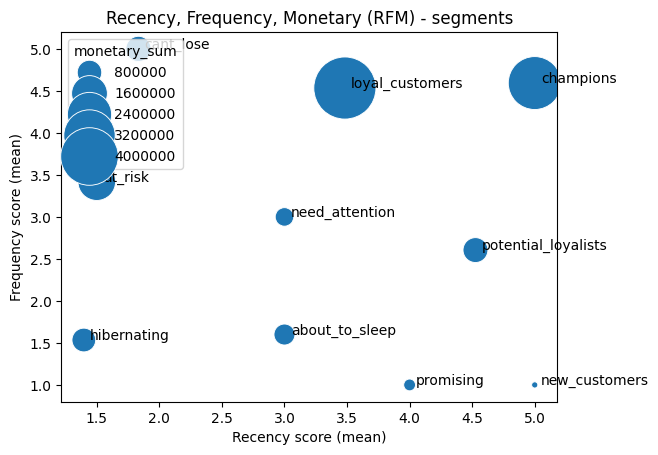

In [24]:
# libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Create figure
#plt.figure(figsize = (15,10))

# use the scatterplot function to build the bubble map
ax = sns.scatterplot(data=summary_df, x="recency_score_mean", y="frequency_score_mean", size="monetary_sum", legend=True, sizes=(20, 2000))

# Annotate each data point
for i, txt in enumerate(summary_df.segment):
   ax.annotate(txt, (summary_df.recency_score_mean.iat[i]+0.05, summary_df.frequency_score_mean.iat[i]))

plt.title("Recency, Frequency, Monetary (RFM) - segments")
plt.xlabel("Recency score (mean)")
plt.ylabel("Frequency score (mean)")

# show the graph
plt.show()